#CafChem tools for finetuning the Chemeleon GNN foundation model.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChem/blob/main/notebooks/Chemeleon_CafChem.ipynb)

## This notebook allows you to:
- Load a CSV and create chemprop datasets and dataloaders
- Finetune Chemeleon on your data.
- Aanalyze the testing set
- Save or load a trained model
- analysis for non-transformed data


## Requirements:
- This notebook will install Chemprop/Chemeleon
- It will pull the CafChem tools from Github.
- It will install all needed libraries.
- Can run on a CPU but is much faster on an L4 GPU.

## Set-up

### Clone Chemeleon from Githib and import libraries

In [1]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
    try:
        import chemprop
    except ImportError:
        !git clone https://github.com/chemprop/chemprop.git
        %cd chemprop
        !pip install .
        %cd examples

Cloning into 'chemprop'...
remote: Enumerating objects: 25138, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 25138 (delta 0), reused 0 (delta 0), pack-reused 25131 (from 1)
Receiving objects: 100% (25138/25138), 863.28 MiB | 26.74 MiB/s, done.
Resolving deltas: 100% (18100/18100), done.
Updating files: 100% (326/326), done.
/content/chemprop
Processing /content/chemprop
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [19]:
!git clone https://github.com/MauricioCafiero/CafChem.git

Cloning into 'CafChem'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 227 (delta 77), reused 36 (delta 36), pack-reused 127 (from 1)
Receiving objects: 100% (227/227), 1.84 MiB | 4.64 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [3]:
import torch
from pathlib import Path
from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
from chemprop.models.model import MPNN
from urllib.request import urlretrieve
import CafChem.CafChemEleon as ccel

urlretrieve(
    r"https://zenodo.org/records/15460715/files/chemeleon_mp.pt",
    "chemeleon_mp.pt",)


('chemeleon_mp.pt', <http.client.HTTPMessage at 0x783af2c04250>)

### Get data from CSV and make Dataframe
- To apply a log10 transformation to the data, put True as the last argument, then use the tool transformed_lists when analyzing.
- Otherwise use False and use lists.

In [4]:
smis, ys = ccel.read_data("/content/905-unique-statins.csv", "Ligand SMILES", ["IC50 (nM)"], True)

### Set-up ChemProp/Chemeleon variables/parameters

In [5]:
mpnn, train_loader, val_loader, test_loader, train_dset, val_dset, test_dset = ccel.make_model(smis, ys, (0.8, 0.1, 0.1))

## Set up training

In [6]:
checkpointing = ModelCheckpoint(
    "checkpoints",  # Directory where model checkpoints will be saved
    "best-{epoch}-{val_loss:.2f}",  # Filename format for checkpoints, including epoch and validation loss
    "val_loss",  # Metric used to select the best checkpoint (based on validation loss)
    mode="min",  # Save the checkpoint with the lowest validation loss (minimization objective)
    save_last=True,  # Always save the most recent checkpoint, even if it's not the best
)

trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=20, # number of epochs to train for
    callbacks=[checkpointing], # Use the configured checkpoint callback
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Train and show test results

In [7]:
trainer.fit(mpnn, train_loader, val_loader)

INFO: You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loading `train_dataloader` to estimate number of stepping batches.
INFO:lightning.pytorch.utilities.rank_zero:Load

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [8]:
results = trainer.test(dataloaders=test_loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at /content/chemprop/examples/checkpoints/best-epoch=14-val_loss=0.14.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/chemprop/examples/checkpoints/best-epoch=14-val_loss=0.14.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/chemprop/examples/checkpoints/best-epoch=14-val_loss=0.14.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint a

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.4352406859397888     │
│         test/rmse         │     0.58351069688797      │
└───────────────────────────┴───────────────────────────┘

## Evaluate

### Make an inference trainer

In [9]:
with torch.inference_mode():
    inftrainer = pl.Trainer(
        logger=None,
        enable_progress_bar=True,
        accelerator="auto",
        devices=1
    )

test_preds = inftrainer.predict(mpnn, test_loader)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-

Predicting: |          | 0/? [00:00<?, ?it/s]

### prepare test data and analyze

In [10]:
full_preds = []
for i in range(len(test_preds)):
  for val in test_preds[i]:
    full_preds.append((10 ** val[0]).item())

In [11]:
trans_ys, untrans_ys, trans_preds, untrans_preds = ccel.transformed_lists(full_preds, test_dset)

regular scale R2 = -0.27, log scale R2 = 0.86


### untransformed data:

In [34]:
full_preds = []
for i in range(len(test_preds)):
  for val in test_preds[i]:
    full_preds.append((val[0]).item())

In [36]:
untrans_ys, untrans_preds = ccel.lists(full_preds, test_dset)

regular scale R2 = 0.94,


### Analyze test data

In [12]:
ccel.values_differences(untrans_ys, untrans_preds)

y =       8.00, pred =       3.35, difference: 4.65
y =    2600.00, pred =    5231.56, difference: 2631.56
y =     260.00, pred =     855.29, difference: 595.29
y =      39.00, pred =     114.22, difference: 75.22
y =       2.30, pred =       6.62, difference: 4.32
y =   92900.00, pred =  134408.73, difference: 41508.73
y =  780000.00, pred =   41225.39, difference: 738774.61
y =    4900.00, pred =    2599.31, difference: 2300.69
y =      40.00, pred =      17.28, difference: 22.72
y =      38.00, pred =      52.38, difference: 14.38
y =    7900.00, pred =    2604.42, difference: 5295.58
y =       8.30, pred =       8.94, difference: 0.64
y =      68.00, pred =      57.62, difference: 10.38
y =    1400.00, pred =      25.13, difference: 1374.87
y =      31.00, pred =      60.03, difference: 29.03
y =    2600.00, pred =    2047.00, difference: 553.00
y =     700.00, pred =      83.20, difference: 616.80
y =      14.00, pred =      12.72, difference: 1.28
y =   10000.00, pred =    9607.8

In [13]:
ccel.values_differences(trans_ys, trans_preds)

y =       0.90, pred =       0.52, difference: 0.38
y =       3.41, pred =       3.72, difference: 0.30
y =       2.41, pred =       2.93, difference: 0.52
y =       1.59, pred =       2.06, difference: 0.47
y =       0.36, pred =       0.82, difference: 0.46
y =       4.97, pred =       5.13, difference: 0.16
y =       5.89, pred =       4.62, difference: 1.28
y =       3.69, pred =       3.41, difference: 0.28
y =       1.60, pred =       1.24, difference: 0.36
y =       1.58, pred =       1.72, difference: 0.14
y =       3.90, pred =       3.42, difference: 0.48
y =       0.92, pred =       0.95, difference: 0.03
y =       1.83, pred =       1.76, difference: 0.07
y =       3.15, pred =       1.40, difference: 1.75
y =       1.49, pred =       1.78, difference: 0.29
y =       3.41, pred =       3.31, difference: 0.10
y =       2.85, pred =       1.92, difference: 0.92
y =       1.15, pred =       1.10, difference: 0.04
y =       4.00, pred =       3.98, difference: 0.02
y =       1.

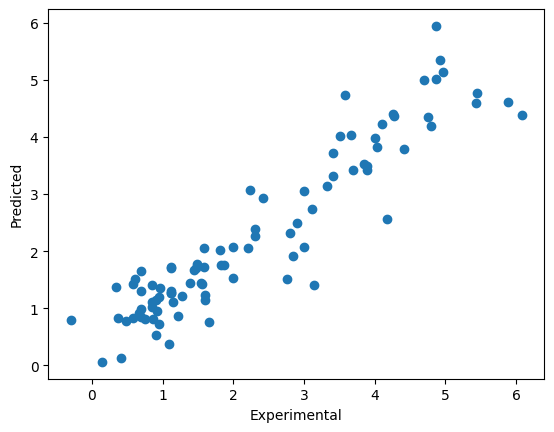

In [14]:
ccel.plot_test(trans_ys, trans_preds)

## Load or save a model
- saving a model
- loading a model and
- loading a dataset or testing
- analyzind dataset

In [40]:
ccel.save_model(mpnn, "/content/AZO_621_test94.pt")

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=2048, bias=False)
    (W_h): Linear(in_features=2048, out_features=2048, bias=False)
    (W_o): Linear(in_features=2120, out_features=2048, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): MeanAggregation()
  (bn): Identity()
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=2048, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): MSE(task_weights=[[1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
  (metrics): ModuleList(
    (0): RMSE(task_weights=[[1.0]])
    (1): MAE(task_weights=[[1.0]])
    (2): MSE(task_weights=[[1.0]])
  )
) model saved

In [15]:
loaded_model = ccel.load_model("/content/AZO_621_test94.pt")

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=2048, bias=False)
    (W_h): Linear(in_features=2048, out_features=2048, bias=False)
    (W_o): Linear(in_features=2120, out_features=2048, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): MeanAggregation()
  (bn): Identity()
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=2048, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): MSE(task_weights=[[1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
  (metrics): ModuleList(
    (0): RMSE(task_weights=[[1.0]])
    (1): MAE(task_weights=[[1.0]])
    (2): MSE(task_weights=[[1.0]])
  )
) model loade

In [17]:
smis, ys = ccel.read_data("/content/212-azo.csv", "SMILES", ["Lmax"], False)

In [21]:
pred_loader, pred_dset = ccel.prediction_dataset(smis, ys) # ys is optional but if not included cannot use some analysis tools below

In [22]:
with torch.inference_mode():
    inftrainer = pl.Trainer(
        logger=None,
        enable_progress_bar=True,
        accelerator="auto",
        devices=1
    )

new_test_preds = inftrainer.predict(loaded_model, pred_loader)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [23]:
full_preds = []
for i in range(len(new_test_preds)):
  for val in new_test_preds[i]:
    full_preds.append((val[0]).item())

In [24]:
untrans_ys, untrans_preds = ccel.lists(full_preds, pred_dset)

regular scale R2 = -0.92,


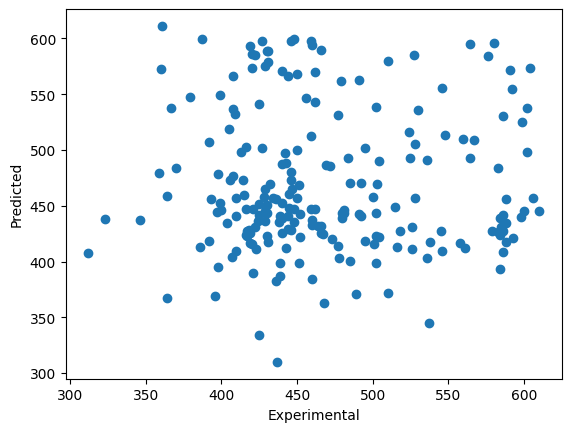

In [25]:
ccel.plot_test(untrans_ys, untrans_preds)

In [26]:
ccel.values_differences(untrans_ys, untrans_preds)

y =     504.00, pred =     422.04, difference: 81.96
y =     528.00, pred =     505.77, difference: 22.23
y =     537.00, pred =     345.12, difference: 191.88
y =     481.00, pred =     446.54, difference: 34.46
y =     468.00, pred =     362.54, difference: 105.46
y =     473.00, pred =     420.60, difference: 52.40
y =     410.00, pred =     441.17, difference: 31.17
y =     419.00, pred =     416.71, difference: 2.29
y =     421.00, pred =     446.95, difference: 25.95
y =     424.00, pred =     436.35, difference: 12.35
y =     409.00, pred =     532.23, difference: 123.23
y =     410.00, pred =     409.32, difference: 0.68
y =     408.00, pred =     566.53, difference: 158.53
y =     417.00, pred =     422.48, difference: 5.48
y =     448.00, pred =     599.87, difference: 151.87
y =     431.00, pred =     579.13, difference: 148.13
y =     452.00, pred =     442.47, difference: 9.53
y =     481.00, pred =     443.06, difference: 37.94
y =     439.00, pred =     398.59, differenc